# Imports

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import classification_report
## estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              HistGradientBoostingClassifier,
                              BaggingClassifier,
                              AdaBoostClassifier)

# Titanic challenge - kaggle

# Baseline

## Load data

In [177]:
df = pd.read_csv("../data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [178]:
df.set_index("PassengerId", inplace=True)

In [179]:
df.duplicated().sum()

0

In [180]:
round(df.isnull().sum().sort_values(ascending=False)/len(df)*100)

Cabin       77.0
Age         20.0
Embarked     0.0
Survived     0.0
Pclass       0.0
Name         0.0
Sex          0.0
SibSp        0.0
Parch        0.0
Ticket       0.0
Fare         0.0
dtype: float64

## Handling missing data

In [181]:
# drop Cabin
df.drop(columns=["Cabin"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


## Train test split

In [182]:
X = df.drop(columns="Survived")
y = df["Survived"]

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, y_train.shape

((712, 9), (712,))

## Numerical columns

In [184]:
num_cols = ["Age", "Fare"]

In [28]:
num_transformer = make_pipeline(
    KNNImputer(),
    RobustScaler()
)
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

## Categorical columns

In [185]:
cat_cols = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
cat_cols

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [186]:
X[cat_cols].head(1)

,Pclass,Sex,SibSp,Parch,Embarked
PassengerId,,,,,
1,3,male,1,0,S


In [187]:
cat_transformer = make_pipeline(
    OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="if_binary")
)
cat_transformer

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

## Basic preproc

In [32]:
basic_preproc = make_column_transformer(
    (num_transformer, num_cols),
    (cat_transformer, cat_cols),
    remainder="drop"
)
basic_preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

## Baseline

In [36]:
baseline_pipe = make_pipeline(
    basic_preproc,
    LogisticRegression(max_iter=1000, solver="lbfgs")
)
baseline_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [37]:
cross_val_score(baseline_pipe, X_train, y_train).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.7921304048064612

In [39]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [40]:
y_pred = baseline_pipe.predict(X_test)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



## First submission

In [42]:
test_df = pd.read_csv("../data/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [43]:
y_pred = baseline_pipe.predict(test_df)

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
submission_df = pd.DataFrame({"PassengerId": test_df.PassengerId, "Survived": y_pred})
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [45]:
from datetime import datetime

file_name = f"""sub_{datetime.today().strftime("%d-%m-%Y@%H:%M:%S")}.csv"""
file_name

'sub_04-07-2024@16:44:59.csv'

In [ ]:
submission_df.set_index("PassengerId", inplace=True)

In [ ]:
submission_df.to_csv(f"../data/submissions/{file_name}")

## SCORE : 0.77

# Finetuning preprocessign

In [188]:
num_cols

['Age', 'Fare']

<AxesSubplot:xlabel='Fare', ylabel='Count'>

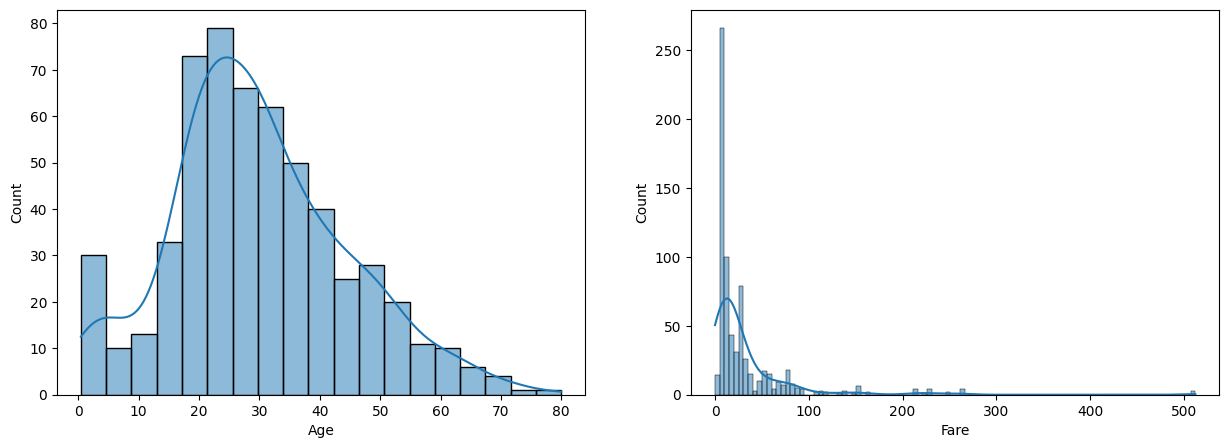

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(X_train.Age, kde=True, ax=axs[0])
sns.histplot(X_train.Fare, kde=True, ax=axs[1])

In [75]:
X.Name.str.extract(r".*,\ (\w*)\.\s").value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Don           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Sir           1
dtype: int64

* Miss : unmarried woman
* Master : under 18 male
* Mrs : married woman
* Rev : priest
* Major : under colonel
* Mlle : same as Miss
* Col : senior rank
* Don : same as mister
* Mme : same as Mrs
* Ms : same as Miss
* Lady : same as Mrs
* Sir : same as Mr
* Jonkheer : same as Mr
* Capt : same as Mr

In [198]:
titles_simplified = {
    "Mr":"Mr",
    "Miss":"Miss",
    "Mrs":"Mrs",
    "Master":"Master",
    "Dr":"Mr",
    "Rev":"Mr",
    "Major":"Mr",
    "Mlle":"Miss",
    "Col":"Mr",
    "Don":"Mr",
    "Mme":"Mrs",
    "Ms":"Mrs",
    "Lady":"Mrs",
    "Sir":"Mr",
    "Capt":"Mr",
    "Jonkheer":"Mr",
    "the Countess": "Mrs"
}

def extract_title(df):
    df["Title"] = df.Name.str.extract(r".*,\ (\w*\s?\w*)\.\s")
    df["Title"].replace(titles_simplified, inplace=True)
    df["Age"] = df.groupby("Title")["Age"].transform(lambda group : group.fillna(group.median()))
    return df

title_extractor = FunctionTransformer(extract_title)
title_extractor

FunctionTransformer(func=<function extract_title at 0x7f63c69c1360>)

In [199]:
custom_age_transformer = make_pipeline(
    title_extractor
)
custom_age_transformer

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7f63c69c1360>))])

In [214]:
num_transformer = make_pipeline(
    KNNImputer(),
    RobustScaler()
)
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

In [215]:
preproc = make_column_transformer(
    (num_transformer, num_cols),
    (cat_transformer, cat_cols),
    remainder="drop"
)
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

In [216]:
pipeline = make_pipeline(
    title_extractor,
    preproc,
    LogisticRegression(max_iter=1000, solver="lbfgs")
)
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7f63c69c1360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [217]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7f63c69c1360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [232]:
cross_val_score(pipeline, X_test, y_test).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.7488888888888889

In [219]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7f63c69c1360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [176]:
X_test[X_test.Title.isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
PassengerId,,,,,,,,,,
760,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,NaN,0,0,110152,86.5,S,NaN


In [211]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 298 to 407
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Name      179 non-null    object 
 2   Sex       179 non-null    object 
 3   Age       179 non-null    float64
 4   SibSp     179 non-null    int64  
 5   Parch     179 non-null    int64  
 6   Ticket    179 non-null    object 
 7   Fare      179 non-null    float64
 8   Embarked  179 non-null    object 
 9   Title     179 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 15.4+ KB


In [220]:
pipeline.predict(X_test)

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0])

In [221]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 298 to 407
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Name      179 non-null    object 
 2   Sex       179 non-null    object 
 3   Age       179 non-null    float64
 4   SibSp     179 non-null    int64  
 5   Parch     179 non-null    int64  
 6   Ticket    179 non-null    object 
 7   Fare      179 non-null    float64
 8   Embarked  179 non-null    object 
 9   Title     179 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 15.4+ KB


In [222]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [231]:
cross_val_score(pipeline, X_test, y_test).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.7488888888888889

In [229]:
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7f63c69c1360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [224]:
y_pred = pipeline.predict(test_df)

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [225]:
submission_df = pd.DataFrame({"PassengerId": test_df.PassengerId, "Survived": y_pred})
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [226]:
submission_df.set_index("PassengerId", inplace=True)

In [227]:
from datetime import datetime

file_name = f"""sub_{datetime.today().strftime("%d-%m-%Y@%H:%M:%S")}.csv"""
file_name

'sub_04-07-2024@19:53:41.csv'

In [228]:
submission_df.to_csv(f"../data/submissions/{file_name}")

## reusing old pipeline on new dataset (old imputer won't do anything)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape

((712, 10), (712,))

In [115]:
cross_val_score(baseline_pipe, X_train, y_train).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8020486555697823

In [116]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [121]:
y_pred = baseline_pipe.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0])

In [123]:
y_test

PassengerId
566    0
161    0
554    1
861    0
242    1
      ..
881    1
92     0
884    0
474    1
638    0
Name: Survived, Length: 179, dtype: int64

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



In [127]:
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

# Finding a better estimator

In [108]:
classifiers = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier()
]

In [109]:
classifier = classifiers[0]

In [110]:
res = {
    "classifier": [],
    "score": []
}

for classifier in classifiers:
    pipeline = make_pipeline(
        basic_preproc,
        classifier
    )
    res["classifier"].append(str(classifier).split("(")[0])
    res["score"].append(cross_val_score(pipeline, X_train, y_train).mean())
res

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be en

{'classifier': ['LogisticRegression',
  'SVC',
  'RandomForestClassifier',
  'HistGradientBoostingClassifier',
  'BaggingClassifier',
  'AdaBoostClassifier'],
 'score': [0.7921304048064612,
  0.8047867625332413,
  0.8117994681374963,
  0.8005811090318133,
  0.783689549886733,
  0.7921107061952132]}